In [ ]:
# Python standard library imports
import time

# Third-party imports for database connection and data manipulation
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
# Third-party imports for mapping
import geopandas as gpd
from folium.plugins import HeatMap
import folium
from shapely.wkb import loads
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors


Section 2: Connection


In [ ]:
# Database connection parameters
dbname = 'DataMining'
user = 'postgres'
password = 'datamining'
host = 'localhost'  # localhost or the server address
port = '5433'  # default PostgreSQL port is 5432
vehicle_id = 181  # Replace with the vehicle ID you are interested in

# Establish a connection to the database
connection_str = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"
engine = create_engine(connection_str)

Section 3: Define and Execute Query


In [ ]:
# Define the query with placeholders for parameters
query_air = """
SELECT *
FROM vehicle_data
WHERE rs_e_inairtemp_pc1 > 65 OR rs_e_inairtemp_pc2 > 65
ORDER BY vehicle_data.timestamps_utc;
"""

# Define the query with placeholders for parameters
query_oil = f"""
SELECT *
FROM vehicle_data
WHERE rs_e_oilpress_pc1 > 115 OR rs_e_oilpress_pc2 > 115
ORDER BY vehicle_data.timestamps_utc;
"""

# Define the query with placeholders for parameters
query_water = f"""
SELECT *
FROM vehicle_data
WHERE rs_e_wattemp_pc1 > 100 OR rs_e_wattemp_pc2 > 100
ORDER BY vehicle_data.timestamps_utc;
"""

In [ ]:
# Execute the query and fetch the data into a DataFrame
#df_air = pd.read_sql_query(query_air, engine)
#df_oil = pd.read_sql_query(query_oil, engine)
#df_water = pd.read_sql_query(query_water, engine)

In [ ]:
# Create a map centered around the average coordinates of Belgium, ! This is heavy to run !
belgium_center = [50.5039, 4.4699]  # Roughly the center of Belgium
map_belgium = folium.Map(location=belgium_center, zoom_start=8)

# Add the data points to the map
#for idx, row in df_air.iterrows():
##    folium.CircleMarker(
#        location=[row['lat'], row['lon']],
#        radius=3,
#        color='blue',
#        fill=True,
#        fill_color='blue',
#        fill_opacity=0.6
##    ).add_to(map_belgium)
#map_belgium

Based on the map we can not see directly a relation between the anomaly locations. 

In [ ]:
# Your query
query_density_air = """
SELECT *
FROM vehicle_data
WHERE RS_E_InAirTemp_PC1 > 65 OR RS_E_InAirTemp_PC2 > 65;
"""

# Execute the query
df_density_air = pd.read_sql_query(query_density_air, engine)

We can try to use DBSCAN to find the locations with high density of anomalies.

In [ ]:
# DBSCAN clustering ! intensive to run !
coords = df_density_air[['lat', 'lon']].to_numpy()
kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian  # 500 meters
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# Add cluster labels to DataFrame
df_density_air['cluster'] = cluster_labels

In [ ]:
# ! Intensive to run !

# Remove noise points
df_no_noise = df_density_air[df_density_air['cluster'] != -1].copy()

# Identify the top 3 biggest clusters
cluster_sizes = df_no_noise.groupby('cluster').size().reset_index(name='size')
top_clusters = cluster_sizes.sort_values('size', ascending=False).head(3)['cluster']

# Filter the DataFrame to only include the top 3 biggest clusters and create a copy to avoid SettingWithCopyWarning
df_top_clusters = df_no_noise[df_no_noise['cluster'].isin(top_clusters)].copy()

# Create a map centered around the mean location of the top clusters
map_top_clusters = folium.Map(location=[df_top_clusters['lat'].mean(), df_top_clusters['lon'].mean()], zoom_start=8)

# Define colors for the top 3 clusters
colors = ['red', 'green', 'blue']

# Add points of the top 3 clusters to the map
for cluster_label, color in zip(top_clusters, colors):
    # Filter the DataFrame to only include points from one cluster at a time
    cluster_points = df_top_clusters[df_top_clusters['cluster'] == cluster_label]
    for _, row in cluster_points.iterrows():
        folium.CircleMarker(
            location=(row['lat'], row['lon']),
            radius=5,
            color=color,
            fill=True,
            fill_color=color
        ).add_to(map_top_clusters)

# Display the map
map_top_clusters

In [26]:
# Create a mapping from cluster number to a more descriptive name
cluster_mapping = {cluster_label: f'Cluster {i+1}' for i, cluster_label in enumerate(top_clusters)}

# Apply this mapping to create a 'Cluster_Label' column
df_top_clusters['Cluster_Label'] = df_top_clusters['cluster'].map(cluster_mapping)

# Add an extra column with 'R3' for every entry
df_top_clusters['Anom_id'] = 'R3'


# Select the relevant columns, including the new 'Cluster_Label' column
columns_to_save = data_list = [
    "mapped_veh_id", "timestamps_utc", "lat", "lon", "rs_e_inairtemp_pc1",
    "rs_e_inairtemp_pc2", "rs_e_oilpress_pc1", "rs_e_oilpress_pc2",
    "rs_e_rpm_pc1", "rs_e_rpm_pc2", "rs_e_wattemp_pc1", "rs_e_wattemp_pc2",
    "rs_t_oiltemp_pc1", "rs_t_oiltemp_pc2", "Cluster_Label", "Anom_id"
]

df_to_save = df_top_clusters[columns_to_save]

# Save the DataFrame to a CSV file
csv_file_path = 'top_3_clusters.csv'
df_to_save.to_csv(csv_file_path, index=False)

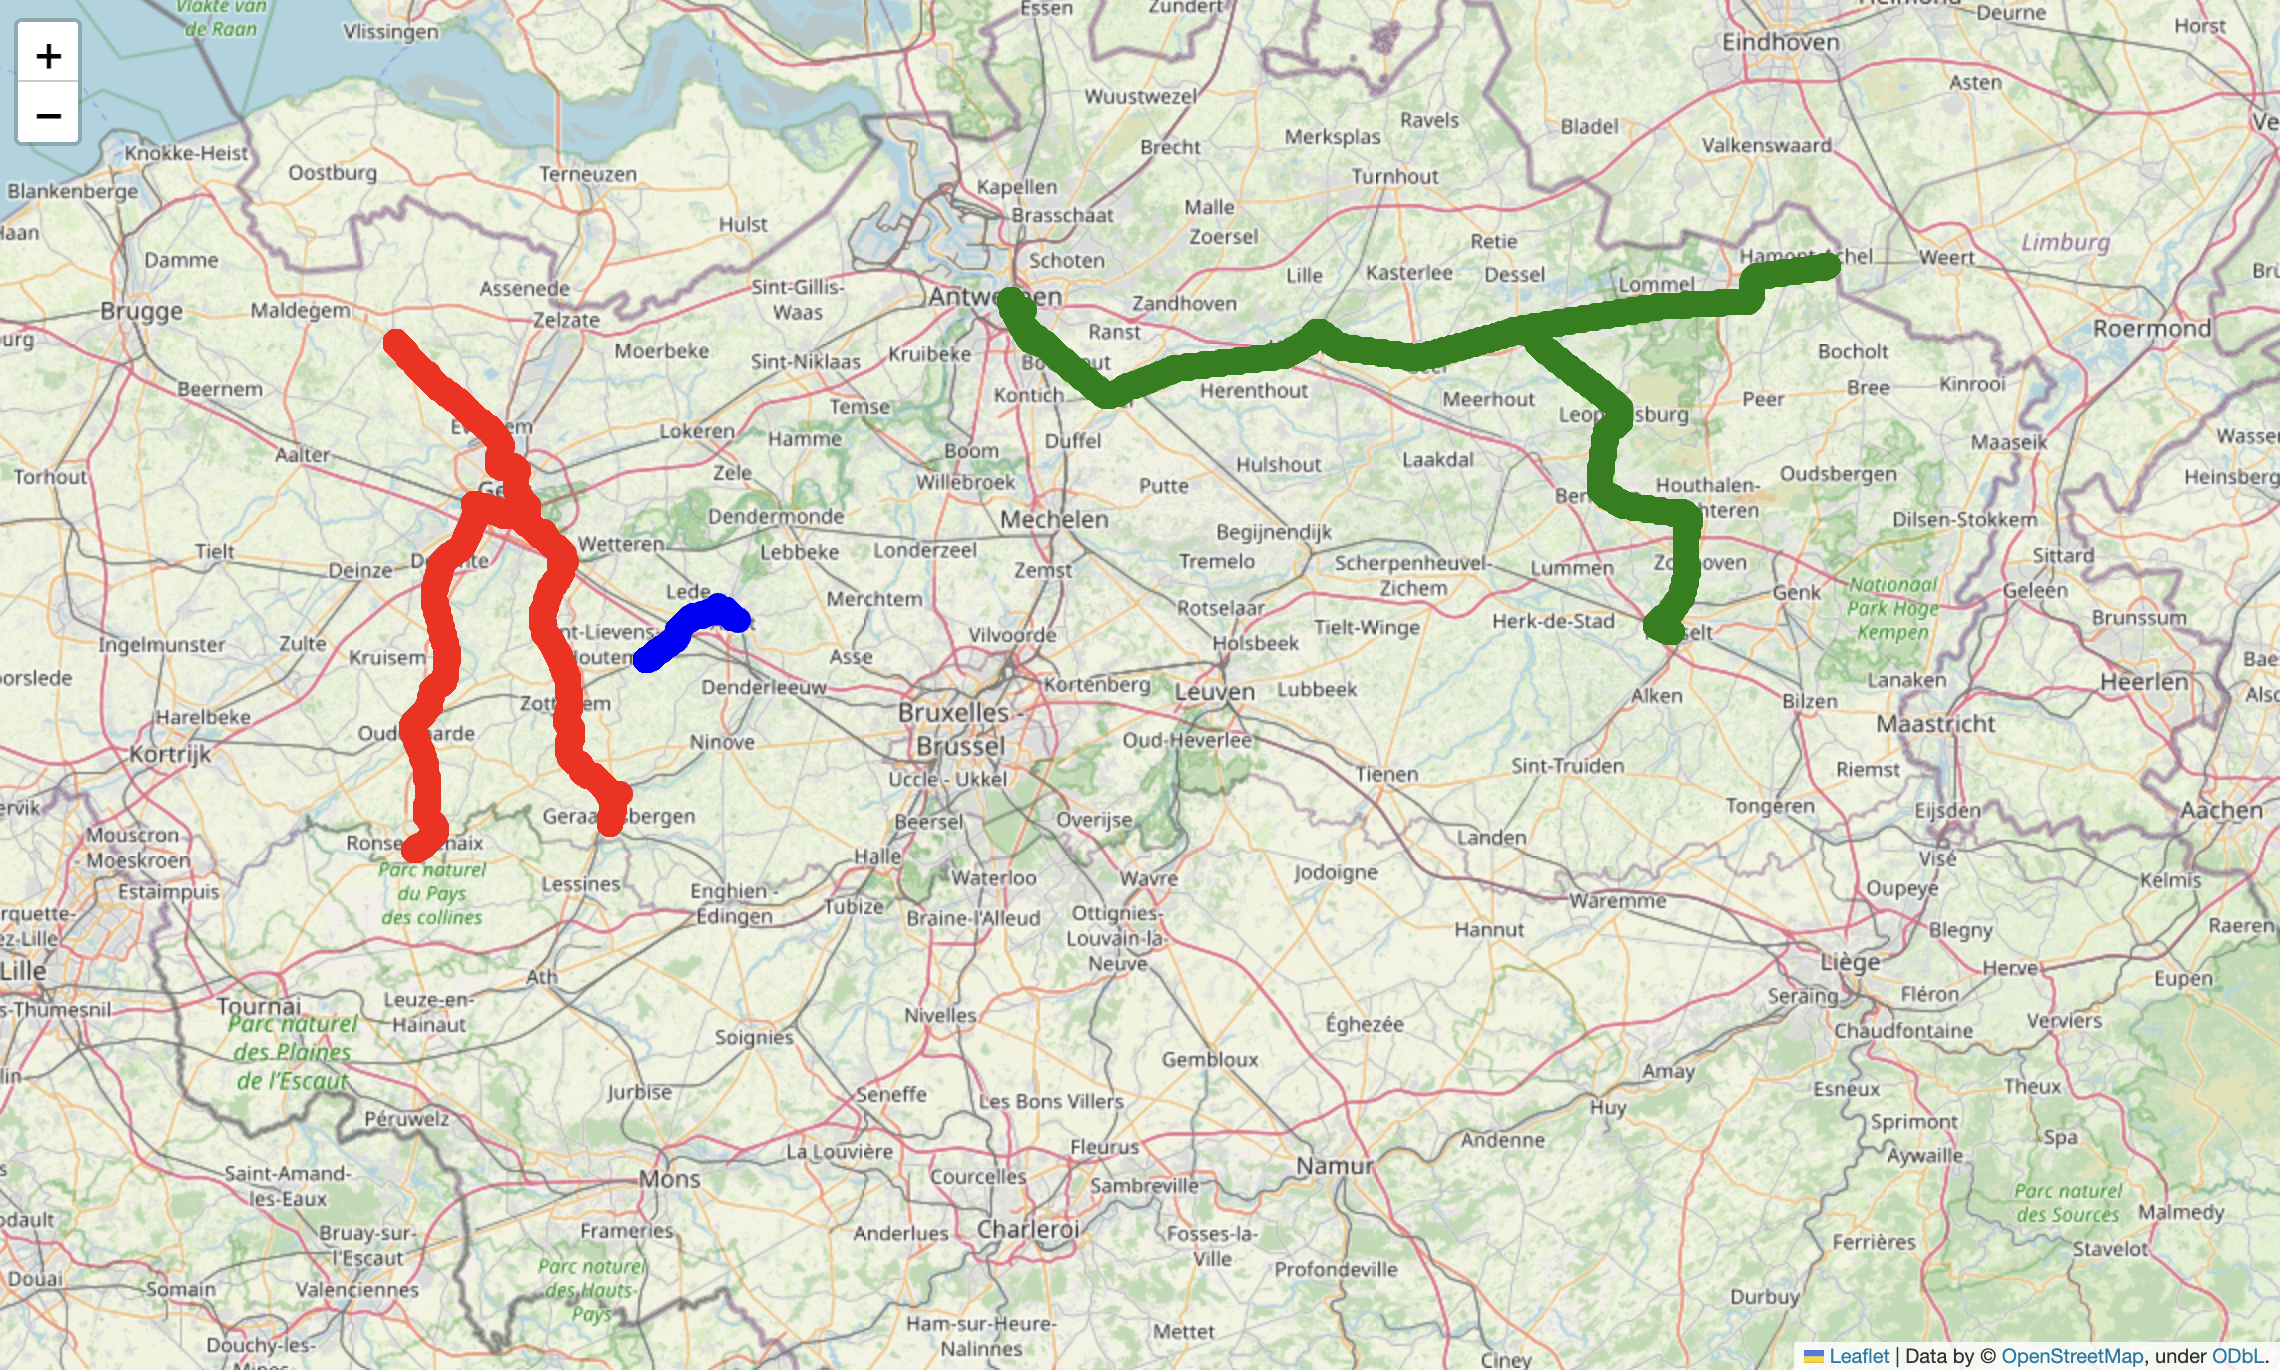

In [27]:
from IPython import display
display.Image("dbscan_clusters.png")

In [35]:
# Execute the query
query_density_temporal = """
SELECT 
    DATE_PART('month', timestamps_UTC) AS month, 
    ST_AsBinary(ST_SnapToGrid(pg_point, 0.01)) AS grid_point_binary, 
    COUNT(*) AS anomaly_count
FROM 
    vehicle_data
WHERE 
    RS_E_InAirTemp_PC1 > 65 OR RS_E_InAirTemp_PC2 > 65
GROUP BY 
    month, 
    grid_point_binary;
"""

df_density_temporal = pd.read_sql_query(query_density_temporal, engine)

# Convert binary grid points to latitude and longitude
df_density_temporal['geometry'] = df_density_temporal['grid_point_binary'].apply(lambda x: loads(bytes(x)))
df_density_temporal['lat'] = df_density_temporal['geometry'].apply(lambda geom: geom.y)
df_density_temporal['lon'] = df_density_temporal['geometry'].apply(lambda geom: geom.x)

In [42]:
import folium
from folium.plugins import HeatMap
from IPython.display import display
import calendar

# Create a separate heatmap for each month
for month in df_density_temporal['month'].unique():
    # Convert the month number to the month name
    month_name = calendar.month_name[int(month)]

    # Print the month name as a title
    print(f"Heatmap for {month_name}")

    # Filter data for the given month
    month_data = df_density_temporal[df_density_temporal['month'] == month]
    
    # Create a base map with a closer zoom
    folium_map = folium.Map(location=[50.8503, 4.3517], zoom_start=8)  # Adjust the zoom_start as needed

    # Add a heatmap layer
    HeatMap(month_data[['lat', 'lon', 'anomaly_count']], radius=10, blur=15, max_zoom=1).add_to(folium_map)

    # Display the map
    display(folium_map)

Heatmap for January


Heatmap for February


Heatmap for March


Heatmap for April


Heatmap for May


Heatmap for June


Heatmap for July


Heatmap for August


Heatmap for September
